# Multiple Linear Regression (HRC Price Prediction for China)
* Predict China's HRC price using multiple linear regression (simple and with polynomial features)

In [633]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [634]:
# Read csv
file_path = '../data/final/wo_na.csv'
df = pd.read_csv(file_path)
df.set_index('Date', inplace=True)
df.index = pd.to_datetime(df.index)

In [635]:
# Define x and y variables
X = df[['Iron Ore (CFR, $/t)', 'HCC (Aus FOB, $/t)',
         'Domestic Scrap (DDP Jiangsu incl. VAT $/t)',
         'Monthly Export of Semis & Finished Steel as % of Production',
         'FAI in urban real estate development (y-o-y) Growth',
         'Automobile Production (y-o-y)', 'Civil Metal-Vessels/Steel Ships (y-o-y)',
         'Household Fridges (y-o-y)', 'Air Conditioner (y-o-y)']]
y = df['HRC (FOB, $/t)']

In [636]:
# Split into training and testing sets with a ratio of 80:20
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_test = X[0:-17], X[-17:]
y_train, y_test = y[0:-17], y[-17:]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(201, 9)
(17, 9)
(201,)
(17,)


In [637]:
# Scale x variables since they are of different magnitudes
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Linear Regression
$$ y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + ... + \beta_n X_n + \epsilon $$

In [638]:
# Model fitting
model = LinearRegression()
model.fit(X_train_scaled, y_train)

LinearRegression()

In [639]:
# Obtain regression model coefficients
print('Intercept: ', model.intercept_)
list(zip(X, model.coef_))

Intercept:  566.0995024875622


[('Iron Ore (CFR, $/t)', 6.654136484739902),
 ('HCC (Aus FOB, $/t)', 40.07313461129165),
 ('Domestic Scrap (DDP Jiangsu incl. VAT $/t)', 108.94152784041917),
 ('Monthly Export of Semis & Finished Steel as % of Production',
  34.14542039971417),
 ('FAI in urban real estate development (y-o-y) Growth', -3.6494467216812594),
 ('Automobile Production (y-o-y)', 6.888385158751959),
 ('Civil Metal-Vessels/Steel Ships (y-o-y)', 12.113565170158918),
 ('Household Fridges (y-o-y)', 13.302303452102132),
 ('Air Conditioner (y-o-y)', -11.404471725448865)]

In [640]:
# Reading var testset predictions
file_path_var_testset = '../data/final/var_testset.csv'
var_testset = pd.read_csv(file_path_var_testset)

X_vartest = var_testset[['Iron Ore (CFR, $/t)_forecast', 'HCC (Aus FOB, $/t)_forecast',
         'Domestic Scrap (DDP Jiangsu incl. VAT $/t)_forecast',
         'Monthly Export of Semis & Finished Steel as % of Production_forecast',
         'FAI in urban real estate development (y-o-y) Growth_forecast',
         'Automobile Production (y-o-y)_forecast', 'Civil Metal-Vessels/Steel Ships (y-o-y)_forecast',
         'Household Fridges (y-o-y)_forecast', 'Air Conditioner (y-o-y)_forecast']].copy()

X_vartest.rename(columns={'Iron Ore (CFR, $/t)_forecast':'Iron Ore (CFR, $/t)', 'HCC (Aus FOB, $/t)_forecast':'HCC (Aus FOB, $/t)',
         'Domestic Scrap (DDP Jiangsu incl. VAT $/t)_forecast':'Domestic Scrap (DDP Jiangsu incl. VAT $/t)',
         'Monthly Export of Semis & Finished Steel as % of Production_forecast':'Monthly Export of Semis & Finished Steel as % of Production',
         'FAI in urban real estate development (y-o-y) Growth_forecast':'FAI in urban real estate development (y-o-y) Growth',
         'Automobile Production (y-o-y)_forecast':'Automobile Production (y-o-y)', 'Civil Metal-Vessels/Steel Ships (y-o-y)_forecast':'Civil Metal-Vessels/Steel Ships (y-o-y)',
         'Household Fridges (y-o-y)_forecast':'Household Fridges (y-o-y)', 'Air Conditioner (y-o-y)_forecast':'Air Conditioner (y-o-y)'}, inplace=True)

X_vartest_scaled = scaler.transform(X_vartest)

In [641]:
# Model predictions
y_pred = model.predict(X_vartest_scaled)

In [642]:
# Error metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs(y_pred - y_test)/np.abs(y_test))
r2 = r2_score(y_test, y_pred)

print('Mean Absolute Error: ', mae)
print('Mean Squared Error: ', mse)
print('Root Mean Squared Error: ', rmse)
print('Mean Absolute Percentage Error: ', mape)
print('R-squared: ', r2)

Mean Absolute Error:  33.79408369050632
Mean Squared Error:  2035.4118096231925
Root Mean Squared Error:  45.11553844988656
Mean Absolute Percentage Error:  0.06807632701524158
R-squared:  -1.1969852508762133


In [643]:
print("Train R²:", model.score(X_train_scaled, y_train))
print("Test R²:", model.score(X_vartest_scaled, y_test))

Train R²: 0.8213240298878157
Test R²: -1.1969852508762133


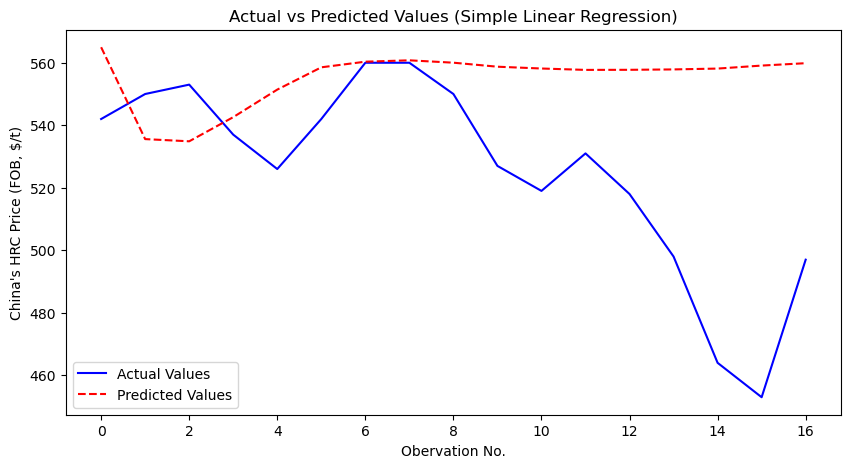

In [644]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(y_test)), y_test, label="Actual Values", color="blue")
plt.plot(np.arange(len(y_pred)), y_pred, label="Predicted Values", color="red", linestyle="dashed")

plt.xlabel("Obervation No.")
plt.ylabel("China's HRC Price (FOB, $/t)")
plt.title("Actual vs Predicted Values (Simple Linear Regression)")
plt.legend()
plt.show()

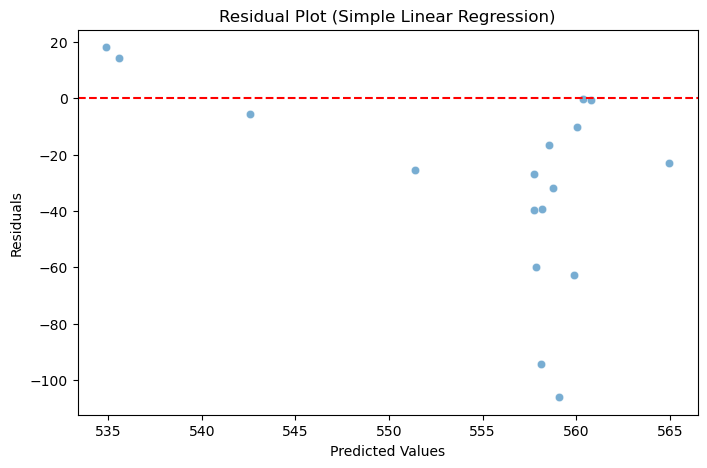

In [645]:
residuals = y_test - y_pred  # Compute residuals

# Plot residuals vs. predicted values
plt.figure(figsize=(8,5))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)  # Scatter plot
plt.axhline(y=0, color="red", linestyle="--")  # Horizontal line at zero
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot (Simple Linear Regression)")
plt.show()

### Input VAR forecasted x variables into Regression model

In [646]:
# Read csv
file_path = '../data/final/var_forecast_1.csv'
var_forecast_df = pd.read_csv(file_path)
var_forecast_df['Date'] = pd.to_datetime(var_forecast_df['Date'])
var_forecast_df.set_index('Date', inplace=True)

file_path2 = '../data/final/var_forecast_2.csv'
var_forecast2_df = pd.read_csv(file_path2)
var_forecast2_df['Date'] = pd.to_datetime(var_forecast2_df['Date'])
var_forecast2_df.set_index('Date', inplace=True)


In [647]:
# Obtain forecasted x variables
forecasted_X = var_forecast_df[['Iron Ore (CFR, $/t)_forecast', 'HCC (Aus FOB, $/t)_forecast',
         'Domestic Scrap (DDP Jiangsu incl. VAT $/t)_forecast',
         'Monthly Export of Semis & Finished Steel as % of Production_forecast',
         'FAI in urban real estate development (y-o-y) Growth_forecast',
         'Automobile Production (y-o-y)_forecast', 'Civil Metal-Vessels/Steel Ships (y-o-y)_forecast',
         'Household Fridges (y-o-y)_forecast', 'Air Conditioner (y-o-y)_forecast']].copy()

forecasted_X.rename(columns={'Iron Ore (CFR, $/t)_forecast':'Iron Ore (CFR, $/t)', 'HCC (Aus FOB, $/t)_forecast':'HCC (Aus FOB, $/t)',
         'Domestic Scrap (DDP Jiangsu incl. VAT $/t)_forecast':'Domestic Scrap (DDP Jiangsu incl. VAT $/t)',
         'Monthly Export of Semis & Finished Steel as % of Production_forecast':'Monthly Export of Semis & Finished Steel as % of Production',
         'FAI in urban real estate development (y-o-y) Growth_forecast':'FAI in urban real estate development (y-o-y) Growth',
         'Automobile Production (y-o-y)_forecast':'Automobile Production (y-o-y)', 'Civil Metal-Vessels/Steel Ships (y-o-y)_forecast':'Civil Metal-Vessels/Steel Ships (y-o-y)',
         'Household Fridges (y-o-y)_forecast':'Household Fridges (y-o-y)', 'Air Conditioner (y-o-y)_forecast':'Air Conditioner (y-o-y)'}, inplace=True)

In [648]:
# Scale x variables
forecasted_X_scaled = scaler.transform(forecasted_X)

In [649]:
# Obtain y forecast
y_forecast = model.predict(forecasted_X_scaled)
y_forecast_new = np.insert(y_forecast, 0, y[-1]) #adding 10/1/2024 value to have a smooth line when plotting

fc_period = pd.date_range(start='10/1/2024', end='3/1/2026', freq='MS')
df_forecast = pd.DataFrame(y_forecast_new, index=fc_period, columns=['HRC (FOB, $/t)_f'])
df_forecast.index.name = 'Date'
df_forecast

,"HRC (FOB, $/t)_f"
Date,
2024-10-01,497.000000
2024-11-01,560.372873
2024-12-01,560.857291
2025-01-01,561.088248
2025-02-01,561.385992
2025-03-01,561.672284
2025-04-01,561.956906
2025-05-01,562.329086
2025-06-01,562.697665


In [650]:
# Export forecasted HRC price in China to a csv file
df_forecast.to_csv('../data/final/multireg_forecast.csv', index=True)

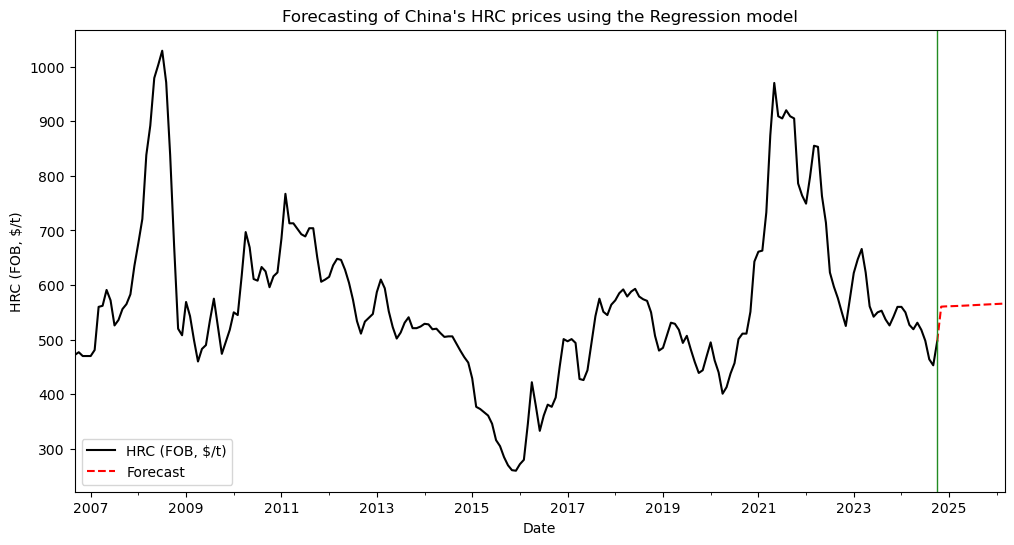

In [651]:
# Plot forecast
fig, ax = plt.subplots(figsize=(12, 6))

df['HRC (FOB, $/t)'].plot(color='k')
df_forecast['HRC (FOB, $/t)_f'].plot(color='r', linestyle ='dashed', label='Forecast')

plt.title("Forecasting of China's HRC prices using the Regression model")
plt.ylabel("HRC (FOB, $/t)")
plt.xlabel("Date")
plt.axvline(x = '2024-10-20', linewidth = 1, color = 'forestgreen', linestyle = 'solid')
ax.legend()

### Report forecast data

In [652]:
# Def code for creating the forecast region
def create_forecast_region(iron_ore, hcc, scrap, export_perc, fai, var_forecast):
    fc_p = pd.date_range(start=var_forecast.index[0], end=var_forecast.index[-1], freq='MS')
    up_down_df = pd.DataFrame(np.nan, index=fc_p, columns=['Iron Ore (CFR, $/t)',
                                               'HCC (Aus FOB, $/t)',
                                               'Domestic Scrap (DDP Jiangsu incl. VAT $/t)',
                                               'Monthly Export of Semis & Finished Steel as % of Production',
                                               'FAI in urban real estate development (y-o-y) Growth',
                                               'Automobile Production (y-o-y)', 'Civil Metal-Vessels/Steel Ships (y-o-y)',
                                               'Household Fridges (y-o-y)', 'Air Conditioner (y-o-y)'])
    up_down_df.index.name = 'Date'
    up_down_df['Iron Ore (CFR, $/t)'] = iron_ore
    up_down_df['HCC (Aus FOB, $/t)'] = hcc
    up_down_df['Domestic Scrap (DDP Jiangsu incl. VAT $/t)'] = scrap
    up_down_df['Monthly Export of Semis & Finished Steel as % of Production'] = export_perc
    up_down_df['FAI in urban real estate development (y-o-y) Growth'] = fai
    up_down_df['Automobile Production (y-o-y)'] = var_forecast['Automobile Production (y-o-y)_forecast']
    up_down_df['Civil Metal-Vessels/Steel Ships (y-o-y)'] = var_forecast['Civil Metal-Vessels/Steel Ships (y-o-y)_forecast']
    up_down_df['Household Fridges (y-o-y)'] = var_forecast['Household Fridges (y-o-y)_forecast']
    up_down_df['Air Conditioner (y-o-y)'] = var_forecast['Air Conditioner (y-o-y)_forecast']
    
    up_down_scaled = scaler.transform(up_down_df)

    up_down_f = model.predict(up_down_scaled)
    up_down_f_new = np.insert(up_down_f, 0, df['HRC (FOB, $/t)'][-1])

    fc_dates = pd.date_range(start='10/1/2024', end='3/1/2026', freq='MS')
    up_down_forecast = pd.DataFrame(up_down_f_new, index=fc_dates, columns=['HRC (FOB, $/t)'])
    up_down_forecast.index.name = 'Date'
    return up_down_forecast


In [653]:
# Forecasting y upside and downside
df_forecast_downside = create_forecast_region(85, 180, 350, 12, 1, var_forecast_df)
df_forecast_upside = create_forecast_region(100, 220, 400, 9, 5, var_forecast_df)

In [654]:
#adding 10/1/2024 value to have a smooth line when plotting
var_f = var_forecast_df['HRC (FOB, $/t)_forecast']
var_f2 = var_forecast2_df['HRC (FOB, $/t)_forecast']
var_f_new = np.insert(var_f, 0, 497)
var_f2_new = np.insert(var_f2, 0, 497)

fc_dates = pd.date_range(start='10/1/2024', end='3/1/2026', freq='MS')
var_f_final = pd.DataFrame(var_f_new, index=fc_dates, columns=['HRC (FOB, $/t)_forecast'])
var_f_final.index.name = 'Date'

var_f2_final = pd.DataFrame(var_f2_new, index=fc_dates, columns=['HRC (FOB, $/t)_forecast'])
var_f2_final.index.name = 'Date'

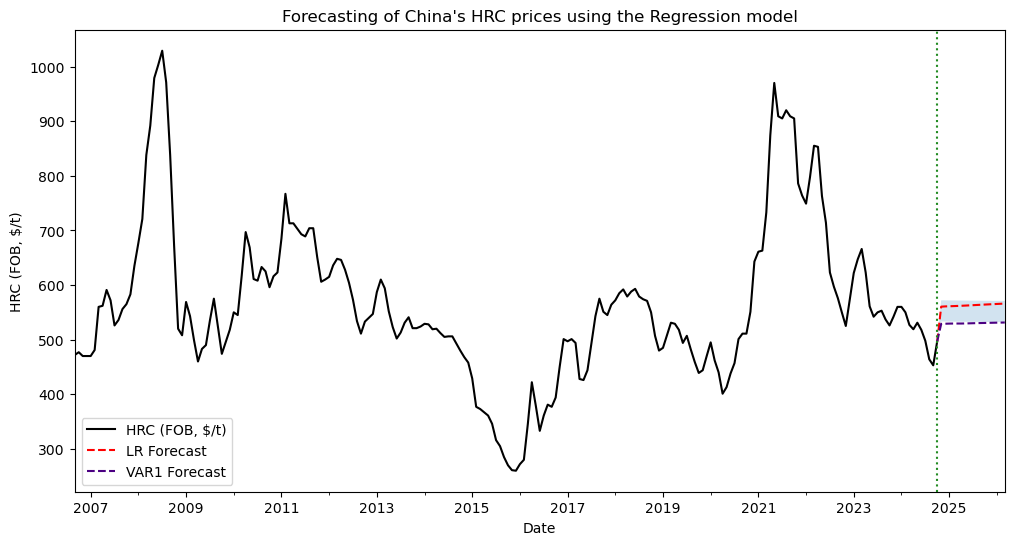

In [655]:
# Plot forecast
fig, ax = plt.subplots(figsize=(12, 6))

df['HRC (FOB, $/t)'].plot(color='k')
df_forecast['HRC (FOB, $/t)_f'].plot(color='r', linestyle ='dashed', label='LR Forecast')
var_f_final['HRC (FOB, $/t)_forecast'].plot(color='indigo', linestyle ='dashed', label='VAR1 Forecast')
#var_f2_final['HRC (FOB, $/t)_forecast'].plot(color='teal', linestyle ='dashed', label='VAR2 Forecast')
fc_period = pd.date_range(start='10/1/2024', end='3/1/2026', freq='MS')
ax.fill_between(x=fc_period, y1=df_forecast_downside['HRC (FOB, $/t)'], y2=df_forecast_upside['HRC (FOB, $/t)'], alpha=0.2)

plt.title("Forecasting of China's HRC prices using the Regression model")
plt.ylabel("HRC (FOB, $/t)")
plt.xlabel("Date")
plt.axvline(x = '2024-10-01', color = 'forestgreen', linestyle = 'dotted')
ax.legend()

## Polynomial Linear Regression (degree = 2)
$$ y = \beta_0 + \sum_{i=1}^{n} \beta_i X_i + \sum_{i=1}^{n} \beta_{ii} X_i^2 + \sum_{i=1}^{n} \sum_{j=i+1}^{n} \beta_{ij} X_i X_j + \epsilon $$

where:  
- $X_i$ are the original factors affecting China's HRC price.  
- $X_i^2$ are the squared terms capturing nonlinear relationships.  
- $X_i$, $X_j$ are interaction terms, representing how two factors together impact China's HRC price.  

**Reasons for introducing polynomial features** 
* The relationship between the factors and HRC price is nonlinear as shown in the simple regression.  
* The residual plot above shows curved patterns in linear regression . 
* The interactions between the factors may be significant.  
* High-degree polynomial regression can overfit the data.

In [482]:
# Define polynomial transformation
degree = 2
poly = PolynomialFeatures(degree)

# Transform BOTH training and testing data
X_train_poly = poly.fit_transform(X_train)  # Fit and transform for training
X_test_poly = poly.transform(X_test)        # Only transform for testing

# Train the model using transformed training data
model = LinearRegression()
model.fit(X_train_poly, y_train)

# Predict using the transformed test data
y_pred_poly = model.predict(X_test_poly)

In [483]:
# Get feature names and coefficients
feature_names = poly.get_feature_names_out(input_features=X.columns)
coefficients = model.coef_

# Display results
pd.DataFrame({"Feature": feature_names, "Coefficient": coefficients})

,Feature,Coefficient
0,1,1.526230e+14
1,"Iron Ore (CFR, $/t)",1.883574e+02
2,"HCC (Aus FOB, $/t)",1.353793e+02
3,Domestic Scrap (DDP Jiangsu incl. VAT $/t),-2.706009e+03
4,Monthly Export of Semis & Finished Steel as % ...,-1.637578e+03
5,FAI in urban real estate development (y-o-y) G...,1.247191e+03
6,Automobile Production (y-o-y),3.488674e+02
7,Civil Metal-Vessels/Steel Ships (y-o-y),-6.177879e+02
8,Household Fridges (y-o-y),3.072457e+03
9,Air Conditioner (y-o-y),9.580229e+01


In [98]:
# Error metrics
mae_poly = mean_absolute_error(y_test, y_pred_poly)
mse_poly = mean_squared_error(y_test, y_pred_poly)
rmse_poly = np.sqrt(mean_squared_error(y_test, y_pred_poly))
r2_poly = r2_score(y_test, y_pred_poly)

print('Mean Absolute Error: ', mae_poly)
print('Mean Squared Error: ', mse_poly)
print('Root Mean Squared Error: ', rmse_poly)
print('R-squared: ', r2_poly)

Mean Absolute Error:  35.39163797551935
Mean Squared Error:  2045.3643790718495
Root Mean Squared Error:  45.225704848811915
R-squared:  0.9127442480911334


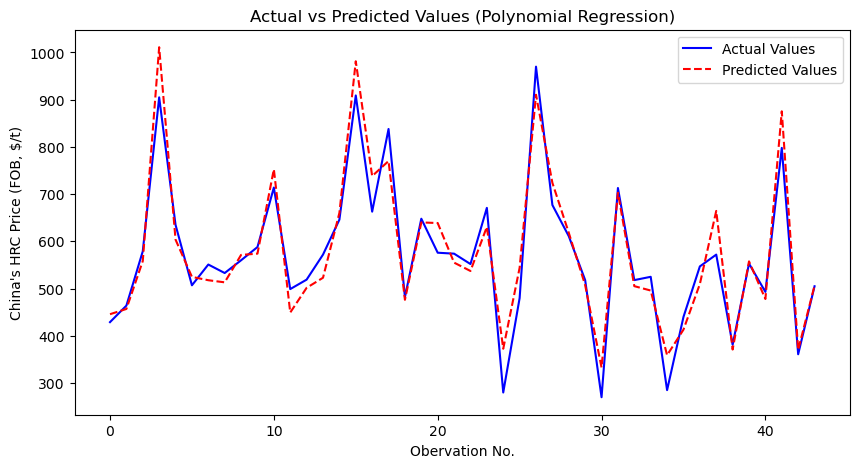

In [99]:
# Assuming y_test and y_pred are 1D arrays
plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(y_test)), y_test, label="Actual Values", color="blue")
plt.plot(np.arange(len(y_pred_poly)), y_pred_poly, label="Predicted Values", color="red", linestyle="dashed")

plt.xlabel("Obervation No.")
plt.ylabel("China's HRC Price (FOB, $/t)")
plt.title("Actual vs Predicted Values (Polynomial Regression)")
plt.legend()
plt.show()

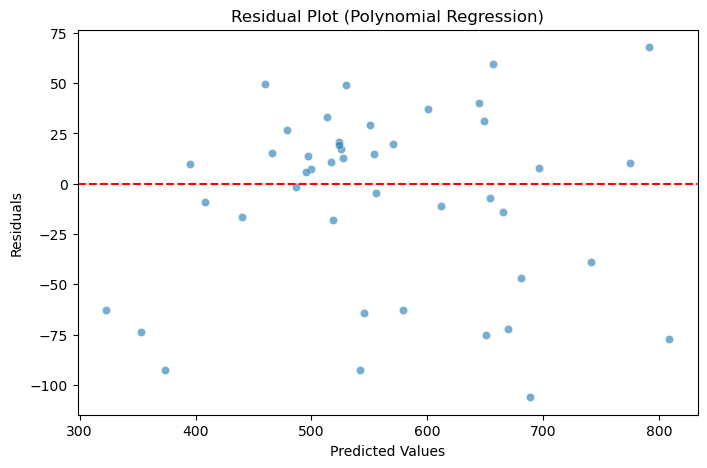

In [100]:
residuals_poly = y_test - y_pred_poly  # Compute residuals

# Plot residuals vs. predicted values
plt.figure(figsize=(8,5))
sns.scatterplot(x=y_pred, y=residuals_poly, alpha=0.6)  # Scatter plot
plt.axhline(y=0, color="red", linestyle="--")  # Horizontal line at zero
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot (Polynomial Regression)")
plt.show()

### Input VAR forecasted x variables into Regression model

In [101]:
# Read csv
file_path = '../data/final/var_forecast.csv'
var_forecast_df = pd.read_csv(file_path)
var_forecast_df.set_index('Date', inplace=True)

In [102]:
# Obtain forecasted x variables
forecasted_X = var_forecast_df[['Iron Ore (CFR, $/t)_forecast', 'HCC (Aus FOB, $/t)_forecast',
         'Domestic Scrap (DDP Jiangsu incl. VAT $/t)_forecast',
         'Monthly Export of Semis & Finished Steel as % of Production_forecast',
         'FAI in urban real estate development (y-o-y) Growth_forecast',
         'Automobile Production (y-o-y)_forecast', 'Civil Metal-Vessels/Steel Ships (y-o-y)_forecast',
         'Household Fridges (y-o-y)_forecast', 'Air Conditioner (y-o-y)_forecast']]

forecasted_X.rename(columns={'Iron Ore (CFR, $/t)_forecast':'Iron Ore (CFR, $/t)', 'HCC (Aus FOB, $/t)_forecast':'HCC (Aus FOB, $/t)',
         'Domestic Scrap (DDP Jiangsu incl. VAT $/t)_forecast':'Domestic Scrap (DDP Jiangsu incl. VAT $/t)',
         'Monthly Export of Semis & Finished Steel as % of Production_forecast':'Monthly Export of Semis & Finished Steel as % of Production',
         'FAI in urban real estate development (y-o-y) Growth_forecast':'FAI in urban real estate development (y-o-y) Growth',
         'Automobile Production (y-o-y)_forecast':'Automobile Production (y-o-y)', 'Civil Metal-Vessels/Steel Ships (y-o-y)_forecast':'Civil Metal-Vessels/Steel Ships (y-o-y)',
         'Household Fridges (y-o-y)_forecast':'Household Fridges (y-o-y)', 'Air Conditioner (y-o-y)_forecast':'Air Conditioner (y-o-y)'}, inplace=True)

/var/folders/kk/49b6qgnj201cbhch83b6xr740000gn/T/ipykernel_18425/165176089.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecasted_X.rename(columns={'Iron Ore (CFR, $/t)_forecast':'Iron Ore (CFR, $/t)', 'HCC (Aus FOB, $/t)_forecast':'HCC (Aus FOB, $/t)',


In [103]:
# Scale and transform x variables
forecasted_X_poly = poly.transform(forecasted_X)

In [104]:
# Obtain y forecast
y_forecast = model.predict(forecasted_X_poly)

fc_period = pd.date_range(start='11/1/2024', end='3/1/2026', freq='MS')
df_forecast = pd.DataFrame(y_forecast, index=fc_period, columns=['HRC (FOB, $/t)_f'])
df_forecast.index.name = 'Date'
df_forecast

,"HRC (FOB, $/t)_f"
Date,
2024-11-01,538.702339
2024-12-01,543.053211
2025-01-01,543.578148
2025-02-01,526.249172
2025-03-01,515.901760
2025-04-01,515.862972
2025-05-01,518.677963
2025-06-01,519.614506
2025-07-01,525.254417


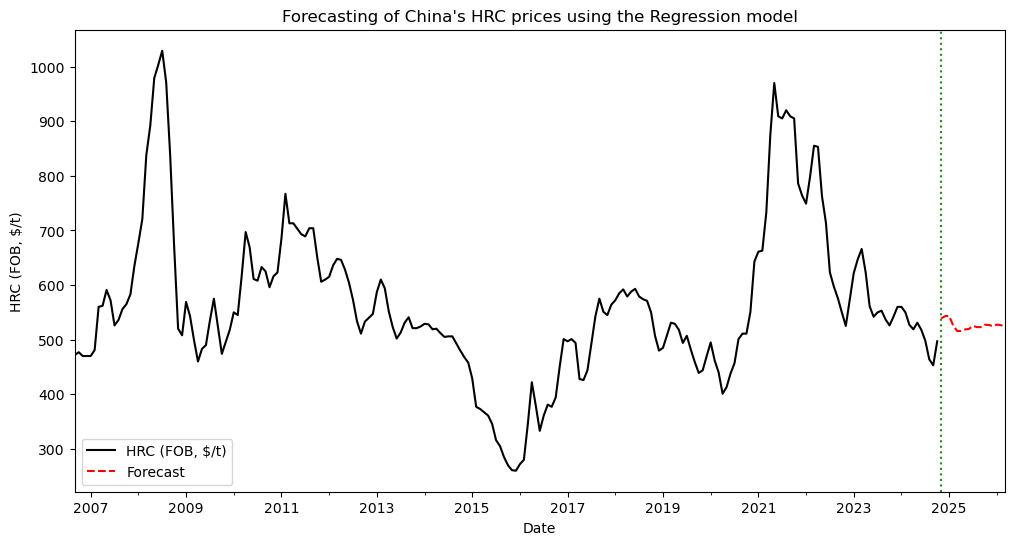

In [105]:
# Plot forecast
fig, ax = plt.subplots(figsize=(12, 6))

df['HRC (FOB, $/t)'].plot(color='k')
df_forecast['HRC (FOB, $/t)_f'].plot(color='r', linestyle ='dashed', label='Forecast')

plt.title("Forecasting of China's HRC prices using the Regression model")
plt.ylabel("HRC (FOB, $/t)")
plt.xlabel("Date")
plt.axvline(x = '2024-11-01', color = 'forestgreen', linestyle = 'dotted')
ax.legend()